In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# set seed to reproduce similar results
np.random.seed(0)

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [3]:
# seperate train, test
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [4]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


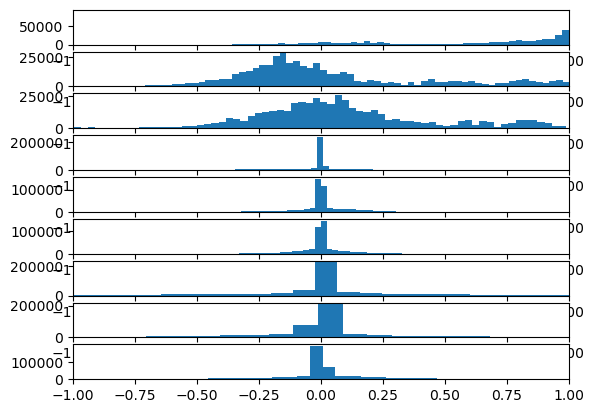

In [5]:
# plot distributions
plot_distributions(trainX)

In [6]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

[ Bi-LSTM ]

In [7]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

model = Sequential()
model.add(Bidirectional(LSTM(100), input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 67s 606ms/step - loss: 1.1297 - accuracy: 0.5253 - val_loss: 0.9286 - val_accuracy: 0.6818
Epoch 2/10
92/92 [==============================] - 48s 521ms/step - loss: 0.8597 - accuracy: 0.6635 - val_loss: 0.8064 - val_accuracy: 0.7097
Epoch 3/10
92/92 [==============================] - 47s 512ms/step - loss: 0.5604 - accuracy: 0.7767 - val_loss: 0.5812 - val_accuracy: 0.8321
Epoch 4/10
92/92 [==============================] - 52s 566ms/step - loss: 0.4054 - accuracy: 0.8512 - val_loss: 0.5591 - val_accuracy: 0.8470
Epoch 5/10
92/92 [==============================] - 51s 555ms/step - loss: 0.3106 - accuracy: 0.8953 - val_loss: 0.4399 - val_accuracy: 0.8851
Epoch 6/10
92/92 [==============================] - 54s 588ms/step - loss: 0.2897 - accuracy: 0.8913 - val_loss: 0.4030 - val_accuracy: 0.8858
Epoch 7/10
92/92 [==============================] - 41s 452ms/step - loss: 0.3001 - accuracy: 0.8825 - val_loss: 0.4522 - val_accuracy: 0.8430

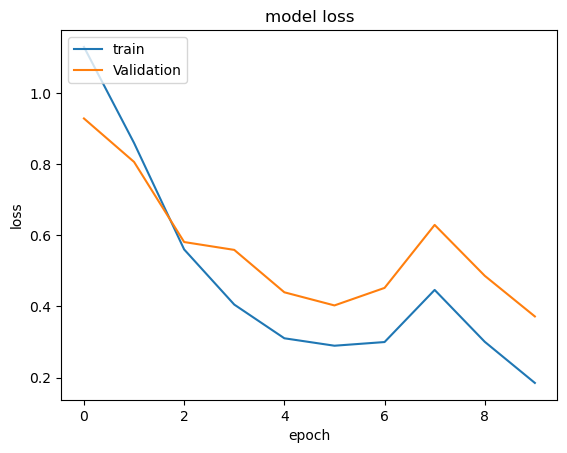

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [11]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the Bi-LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the Bi-LSTM model 0.8812351822853088
93/93 [==============================] - 7s 58ms/step


In [12]:
predictions

array([[6.9684461e-03, 3.7552407e-01, 1.0143040e-02, 5.4766707e-02,
        2.3978058e-01, 3.1281710e-01],
       [3.4922987e-02, 2.7808636e-02, 2.0280003e-03, 2.0033802e-01,
        7.3065931e-01, 4.2430740e-03],
       [4.0543642e-02, 1.7447237e-02, 1.8541048e-03, 2.3554766e-01,
        7.0138079e-01, 3.2265713e-03],
       ...,
       [2.1718314e-02, 9.7697431e-01, 1.2290793e-03, 3.3946305e-06,
        7.1289542e-05, 3.6326142e-06],
       [3.2055885e-02, 9.6285647e-01, 2.3825890e-03, 2.8119647e-04,
        2.1771276e-03, 2.4672050e-04],
       [3.1838536e-02, 9.6325684e-01, 2.4238117e-03, 2.2664499e-04,
        2.1098224e-03, 1.4428981e-04]], dtype=float32)

In [13]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[422  37  37   0   0   0]
 [ 20 443   7   0   1   0]
 [  2   9 409   0   0   0]
 [  0   4   0 370  94  23]
 [  1  30   0  63 436   2]
 [  0  20   0   0   0 517]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.95      0.85      0.90       496
           2       0.82      0.94      0.87       471
           3       0.90      0.97      0.94       420
           4       0.85      0.75      0.80       491
           5       0.82      0.82      0.82       532
           6       0.95      0.96      0.96       537

    accuracy                           0.88      2947
   macro avg       0.88      0.88      0.88      2947
weighted avg       0.88      0.88      0.88      2947



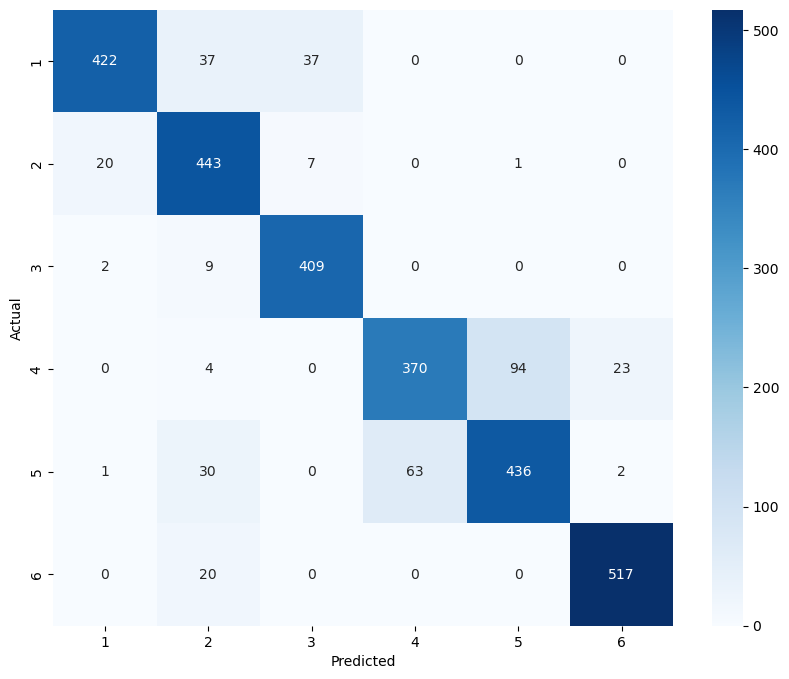

In [14]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

[ GRU ]

In [15]:
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

model = Sequential()
model.add(GRU(100, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))


In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 37s 319ms/step - loss: 1.3006 - accuracy: 0.4569 - val_loss: 1.1637 - val_accuracy: 0.5486
Epoch 2/10
92/92 [==============================] - 26s 278ms/step - loss: 0.9967 - accuracy: 0.5623 - val_loss: 1.1214 - val_accuracy: 0.5595
Epoch 3/10
92/92 [==============================] - 26s 280ms/step - loss: 0.8182 - accuracy: 0.6577 - val_loss: 0.6289 - val_accuracy: 0.7865
Epoch 4/10
92/92 [==============================] - 28s 301ms/step - loss: 0.4611 - accuracy: 0.8237 - val_loss: 0.4851 - val_accuracy: 0.8253
Epoch 5/10
92/92 [==============================] - 25s 273ms/step - loss: 0.2927 - accuracy: 0.8966 - val_loss: 0.2957 - val_accuracy: 0.8939
Epoch 6/10
92/92 [==============================] - 24s 260ms/step - loss: 0.1871 - accuracy: 0.9337 - val_loss: 0.3052 - val_accuracy: 0.9109
Epoch 7/10
92/92 [==============================] - 27s 296ms/step - loss: 0.1672 - accuracy: 0.9390 - val_loss: 0.4606 - val_accuracy: 0.9116

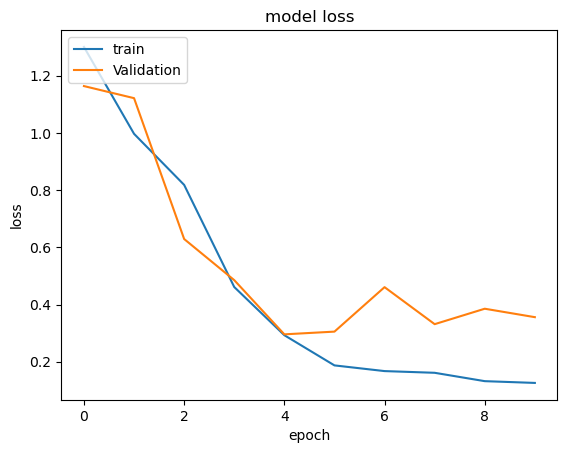

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [19]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the GRU model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the GRU model 0.9039701223373413
93/93 [==============================] - 8s 73ms/step


In [20]:
predictions

array([[6.20447274e-04, 2.31650061e-04, 3.71275783e-05, 3.33662471e-03,
        9.95774090e-01, 9.11017395e-08],
       [7.61490257e-04, 2.32841965e-04, 2.86360482e-05, 2.75599863e-03,
        9.96220887e-01, 7.33620880e-08],
       [6.83861435e-04, 2.09853446e-04, 2.47083317e-05, 2.66107684e-03,
        9.96420383e-01, 6.48320224e-08],
       ...,
       [1.04771687e-04, 9.97227490e-01, 2.66751018e-03, 2.71371405e-08,
        2.18291390e-07, 1.46170684e-08],
       [8.58238782e-05, 9.99864817e-01, 4.92144791e-05, 6.67836852e-09,
        6.10079027e-08, 6.88050950e-10],
       [1.66353886e-04, 9.99766290e-01, 6.72645401e-05, 1.40542307e-08,
        1.05750381e-07, 1.04390141e-09]], dtype=float32)

In [21]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[455  12  29   0   0   0]
 [ 18 437  16   0   0   0]
 [  0   7 413   0   0   0]
 [  4   1   2 355 129   0]
 [  5   0   0  42 485   0]
 [  0  15   3   0   0 519]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.94      0.92      0.93       496
           2       0.93      0.93      0.93       471
           3       0.89      0.98      0.94       420
           4       0.89      0.72      0.80       491
           5       0.79      0.91      0.85       532
           6       1.00      0.97      0.98       537

    accuracy                           0.90      2947
   macro avg       0.91      0.90      0.90      2947
weighted avg       0.91      0.90      0.90      2947



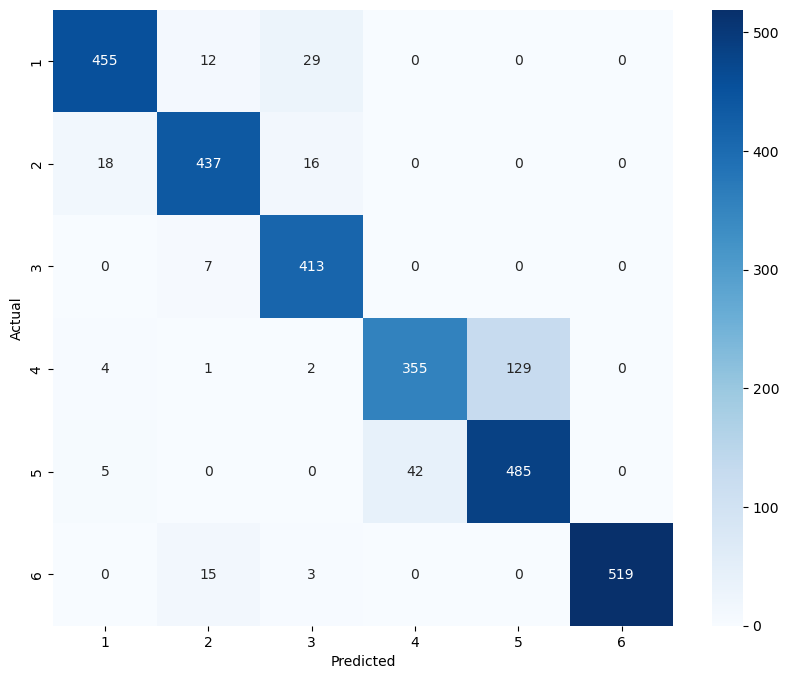

In [22]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

[ Bi-GRU ]

In [23]:
from keras.models import Sequential
from keras.layers import Bidirectional, GRU, Dropout, Dense

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

model = Sequential()
model.add(Bidirectional(GRU(100), input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 54s 466ms/step - loss: 1.1815 - accuracy: 0.5130 - val_loss: 1.1218 - val_accuracy: 0.5432
Epoch 2/10
92/92 [==============================] - 37s 401ms/step - loss: 0.8376 - accuracy: 0.6618 - val_loss: 0.6096 - val_accuracy: 0.7818
Epoch 3/10
92/92 [==============================] - 37s 405ms/step - loss: 0.3892 - accuracy: 0.8607 - val_loss: 0.3968 - val_accuracy: 0.8722
Epoch 4/10
92/92 [==============================] - 36s 389ms/step - loss: 0.2344 - accuracy: 0.9119 - val_loss: 0.3143 - val_accuracy: 0.8994
Epoch 5/10
92/92 [==============================] - 38s 417ms/step - loss: 0.1663 - accuracy: 0.9352 - val_loss: 0.2577 - val_accuracy: 0.9048
Epoch 6/10
92/92 [==============================] - 38s 415ms/step - loss: 0.1417 - accuracy: 0.9435 - val_loss: 0.3218 - val_accuracy: 0.9109
Epoch 7/10
92/92 [==============================] - 39s 422ms/step - loss: 0.1326 - accuracy: 0.9466 - val_loss: 0.2218 - val_accuracy: 0.9191

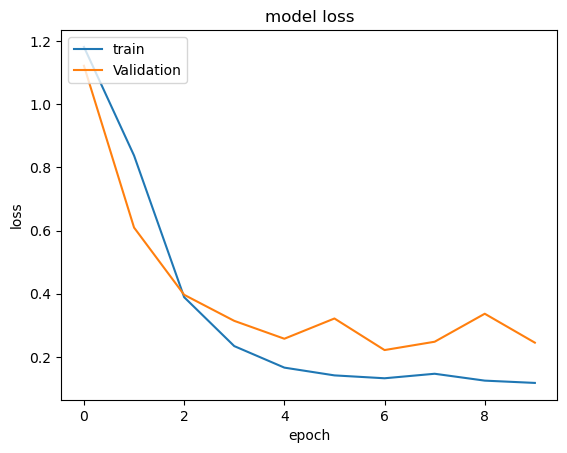

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [27]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the Bi-GRU model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the Bi-GRU model 0.8951476216316223
93/93 [==============================] - 6s 43ms/step


In [28]:
predictions

array([[2.39988975e-03, 1.55188457e-06, 4.16450675e-05, 4.04476747e-03,
        9.93512213e-01, 1.13940173e-08],
       [5.52479061e-04, 4.30872069e-06, 2.38205466e-05, 6.90021180e-03,
        9.92519140e-01, 4.14083097e-08],
       [4.59594739e-04, 3.92780157e-06, 2.38172452e-05, 6.80547720e-03,
        9.92707193e-01, 3.60344252e-08],
       ...,
       [2.68076663e-04, 9.99727190e-01, 1.98666885e-06, 4.20143387e-09,
        8.24816127e-09, 2.78952143e-06],
       [4.76010115e-04, 9.99485731e-01, 1.61259104e-05, 4.80506230e-08,
        1.08868996e-07, 2.20049824e-05],
       [7.41979966e-05, 9.99693394e-01, 7.64941869e-05, 1.21100925e-08,
        7.33330339e-08, 1.55960355e-04]], dtype=float32)

In [29]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[451   5  40   0   0   0]
 [ 21 419  30   0   1   0]
 [  5   1 414   0   0   0]
 [  5   4   0 399  83   0]
 [  4   1   0  84 443   0]
 [  0  25   0   0   0 512]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.93      0.91      0.92       496
           2       0.92      0.89      0.90       471
           3       0.86      0.99      0.92       420
           4       0.83      0.81      0.82       491
           5       0.84      0.83      0.84       532
           6       1.00      0.95      0.98       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



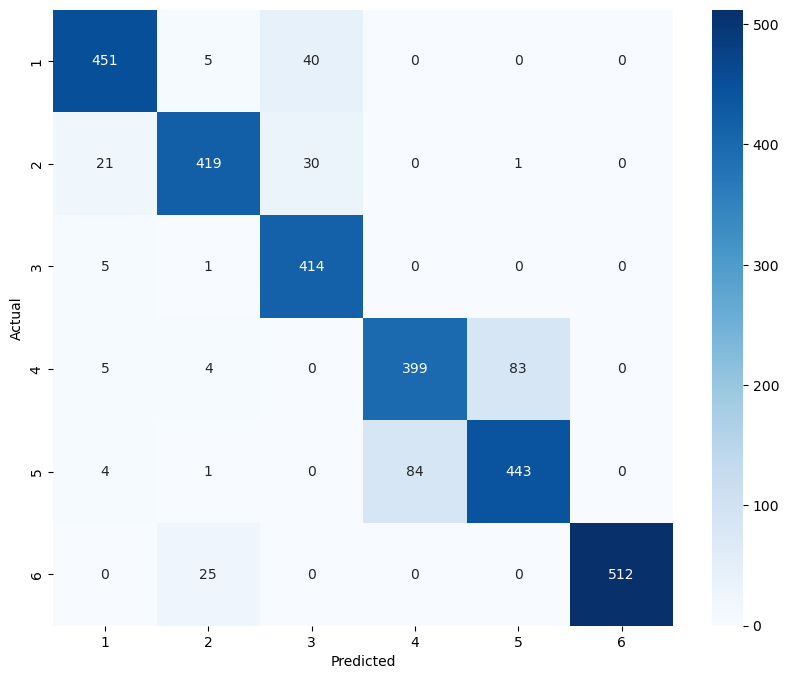

In [30]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

[ CNN + LSTM ]

In [31]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Flatten

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 31s 262ms/step - loss: 0.9173 - accuracy: 0.6018 - val_loss: 0.5740 - val_accuracy: 0.7471
Epoch 2/10
92/92 [==============================] - 23s 247ms/step - loss: 0.4453 - accuracy: 0.8085 - val_loss: 0.5167 - val_accuracy: 0.8300
Epoch 3/10
92/92 [==============================] - 23s 250ms/step - loss: 0.2665 - accuracy: 0.9061 - val_loss: 0.3722 - val_accuracy: 0.8708
Epoch 4/10
92/92 [==============================] - 21s 224ms/step - loss: 0.1702 - accuracy: 0.9408 - val_loss: 0.3704 - val_accuracy: 0.8912
Epoch 5/10
92/92 [==============================] - 23s 246ms/step - loss: 0.1663 - accuracy: 0.9373 - val_loss: 0.3795 - val_accuracy: 0.8980
Epoch 6/10
92/92 [==============================] - 23s 246ms/step - loss: 0.1511 - accuracy: 0.9449 - val_loss: 0.3831 - val_accuracy: 0.8851
Epoch 7/10
92/92 [==============================] - 22s 243ms/step - loss: 0.2347 - accuracy: 0.9201 - val_loss: 0.3230 - val_accuracy: 0.8933

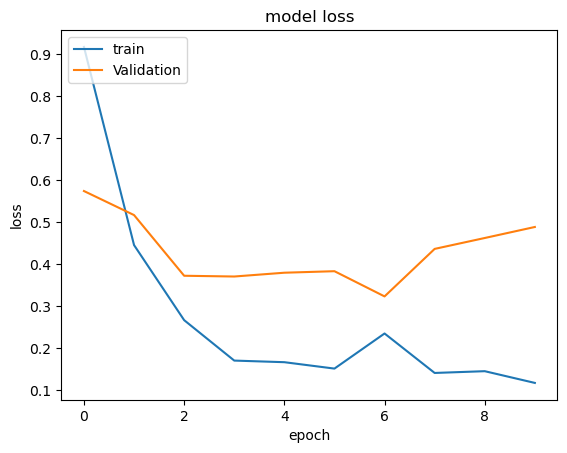

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [35]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN + LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the CNN + LSTM model 0.8910756707191467
93/93 [==============================] - 9s 80ms/step


In [36]:
predictions

array([[7.6710727e-05, 2.7520164e-05, 1.8429307e-06, 1.4603595e-02,
        9.8528880e-01, 1.5264467e-06],
       [6.8880247e-05, 2.7478060e-05, 1.7053356e-06, 1.4220148e-02,
        9.8568034e-01, 1.4400729e-06],
       [7.0044603e-05, 2.8408578e-05, 1.7205623e-06, 1.4015014e-02,
        9.8588341e-01, 1.4658984e-06],
       ...,
       [6.7034169e-05, 9.9964774e-01, 1.0809232e-04, 2.2366394e-05,
        1.1622122e-04, 3.8476905e-05],
       [1.1778742e-04, 9.9950886e-01, 1.0140508e-04, 3.6568268e-05,
        2.0198412e-04, 3.3343611e-05],
       [7.1985756e-05, 9.9979705e-01, 4.7301259e-05, 1.1294916e-05,
        6.4537147e-05, 7.7881305e-06]], dtype=float32)

In [37]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[436  23  37   0   0   0]
 [  2 432  37   0   0   0]
 [  0   3 417   0   0   0]
 [  2  25   0 375  89   0]
 [  1   0   0  64 467   0]
 [  0  38   0   0   0 499]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.99      0.88      0.93       496
           2       0.83      0.92      0.87       471
           3       0.85      0.99      0.92       420
           4       0.85      0.76      0.81       491
           5       0.84      0.88      0.86       532
           6       1.00      0.93      0.96       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.90      0.89      0.89      2947



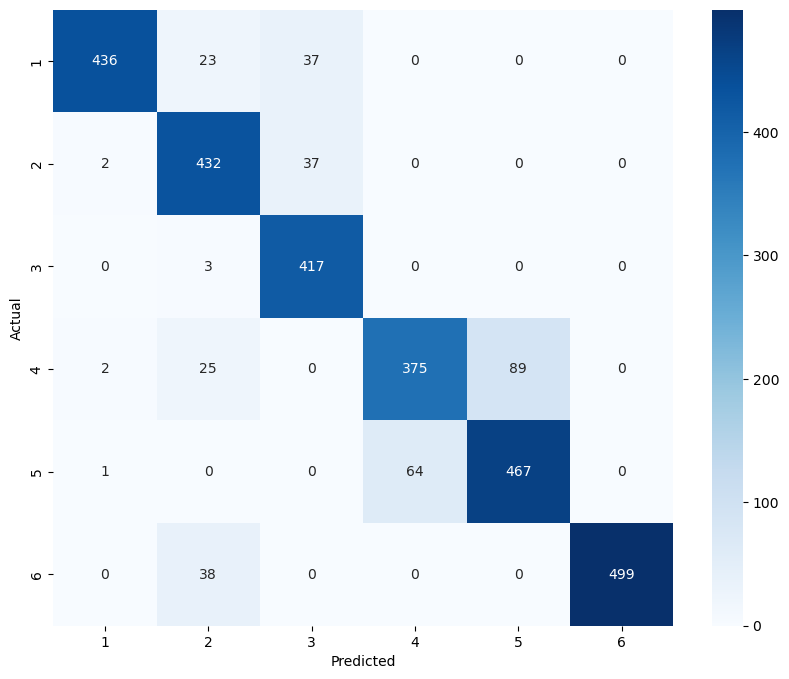

In [38]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)